In [1]:
import sys, pickle
sys.path.append('../src')
import numpy as np
from scipy.linalg import svd
from scipy.stats import permutation_test
from tqdm import tqdm
from matplotlib import colormaps
import matplotlib.pyplot as plt
from utils import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

In [2]:
AUD_MAP_TYPE, TID = 'gaussian', '0'
with open('../results/EIrec_weights_evolve_%s_map_EE_%s.pkl' % (AUD_MAP_TYPE, TID), 'rb') as f:
    Ws = pickle.load(f)
NE = Ws['JEE'][0].shape[0]
fname = '../realistic_auditory_processing/learned_song_responses.npz'
_, _, netEIrec, aud_mapping = load_models('../results/', AUD_MAP_TYPE, 'EE', TID)
aud = read_realistic_input(fname, NE, mean=2, scale=3, mapping=aud_mapping, mapping_args=None)[0]
aud = aud['ctrl'].mean(axis=0)[:,::10].T # take mean and subsample

In [3]:
svds = []
for w in Ws['JEE']:
    J = np.block([[w.toarray(), -netEIrec.JEI.toarray()*2],
                  [netEIrec.JIE.toarray(), -netEIrec.JII.toarray()*2]])
    svds.append(svd(J))
    
f = lambda sv: correlation(sv[0][:NE,:].T, aud, dim=2)
corr_song_sv = np.stack(list(map(f, svds)))
f = lambda sv: svds[0][0].T @ sv[0]
pwsim_sv = np.stack(list(map(f, svds)))

1
7


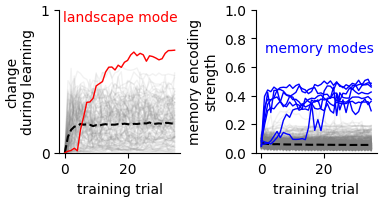

In [9]:
change = 1 - np.abs(pwsim_sv[:,:,:100]).max(axis=1)
i_max = np.argmax(change[-1]) # max change at the last time step
print(i_max)
i_other = [i for i in range(change.shape[1]) if i != i_max]
fig, ax = plt.subplots(1, 2, figsize=(3.8,2))
ax[0].plot(change, c='grey', alpha=0.1, lw=1)
ax[0].plot(change[:,i_other].mean(axis=1), c='k', ls='--')
ax[0].plot(change[:,i_max], c='r', lw=1)
ax[0].text(change.shape[0], 0.9, 'landscape mode', ha='right', va='bottom', color='r')
ax[0].set(ylabel='change\nduring learning', yticks=[0, 1], ylim=[0, 1])
ax[0].set_xlabel('training trial', va='top')

corr_song_evo = np.abs(corr_song_sv).max(axis=-1)
mask = corr_song_evo[-1] > corr_song_evo[0].max()+0.05
print(sum(mask))
ax[1].plot(corr_song_evo[:,~mask], c='grey', alpha=0.1, lw=1)
ax[1].plot(corr_song_evo[:,~mask].mean(axis=1), c='k', ls='--')
ax[1].plot(corr_song_evo[:,mask], c='b', alpha=1, lw=1)
ax[1].text(change.shape[0], 0.7, 'memory modes', ha='right', c='b')
ax[1].set(ylabel='memory encoding\nstrength', ylim=[0, 1])
ax[1].set_xlabel('training trial', va='top')
fig.savefig('../svg/supplementary/mode_learning_curves_realistic.svg')

In [5]:
svd_pre, svd_post = svds[0], svds[-1]

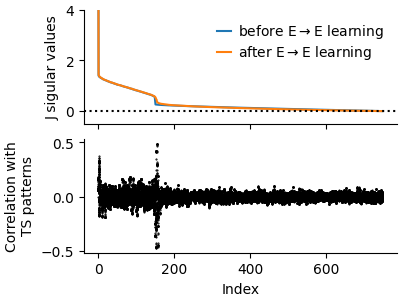

In [6]:
fig, ax = plt.subplots(2, figsize=(4,3), sharex='all')
ax[0].plot(svd_pre[1], label='before E$\\to$E learning')
ax[0].plot(svd_post[1], label='after E$\\to$E learning')
ax[0].axhline(0, ls=':', c='k')
ax[0].set(ylabel='J sigular values', ylim=[-0.5, 4])
ax[0].legend()
c = correlation(svd_post[0][:NE,:].T, aud, dim=2)
ax[1].plot(c, '.', ms=1, color='k')
ax[1].set(xlabel='Index', ylabel='Correlation with\nTS patterns')
fig.savefig('../svg/supplementary/svd_J_full_realistic.svg')

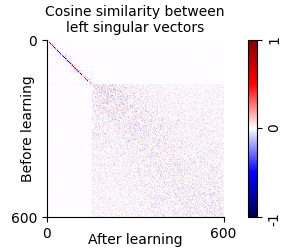

In [7]:
fig, ax = plt.subplots(1, figsize=(3, 2.5))
i = 600
im = ax.imshow(svd_pre[0][:,:i].T @ svd_post[0][:,:i], vmin=-1, vmax=1, 
               interpolation='none', cmap='seismic', aspect=1)
ax.set(xticks=[0,i], yticks=[0,i],
       title='Cosine similarity between\nleft singular vectors')
ax.set_xlabel('\nAfter learning', va='bottom')
ax.set_ylabel('\nBefore learning', va='top')
cax = fig.colorbar(im, ax=ax, fraction=0.04)
cax.set_ticks([-1,0,1], labels=[-1,0,1], rotation=90)
fig.savefig('../svg/supplementary/left_sv_similarity_full_realistic.svg')

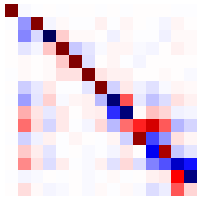

In [8]:
fig, ax = plt.subplots(1, figsize=(2,2))
i = 15
ax.imshow(svd_pre[0][:,:i].T @ svd_post[0][:,:i], vmin=-1, vmax=1, 
          interpolation='none', cmap='seismic', aspect=1)
ax.set_axis_off()
fig.savefig('../svg/supplementary/left_sv_similarity_zoomin_realistic.png')